**извлечение признаков из текста на естественном языке**

классификатор текстов лемматизация+TfidfVectorizer

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

/usr/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'0.23.2'

In [4]:
from pymorphy2 import MorphAnalyzer

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
2006,"Опорный полузащитник «Атлетико Паранаэнсе»может продолжить карьеру в «Зените», утверждает Tretis TV.\n\nПо информации источника, клубы уже ведут переговоры, которые находятся в продвинутой стадии....",sport
2702,Apple может вложить до $1 млрд в фонд SoftBank — СМИ Итоги переговоров пока неизвестны\n\nКомпания Apple обсудила с японской телекоммуникационной компанией SoftBank возможность вложений до $1 млрд...,tech


## токенизация и очистка

In [6]:
# лемматизация и очистка с помощью пакета морфологического анализа

morph = MorphAnalyzer()

# NOUN	существительное
# VERB	глагол
# ADJF	прилагательное
def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
    if not morph.word_is_known(w): return ''
    p = morph.parse(w)[0] 
    return p.normal_form if (p.tag.POS in pos_types) else ''

def string_normalizer(s):
    return re.sub(r'[\W]+',' ',s.lower().replace('ё','е'))

def text_normalizer_tokenize(s):
    return [ word_normalizer(w) for w in string_normalizer(s).split() ]

In [7]:
data['ctext'] = data['text'].progress_apply( text_normalizer_tokenize )

100%|██████████| 3196/3196 [01:41<00:00, 31.63it/s]


In [8]:
# собираем словарь
vcb0 = [ set(s) for s in data['ctext'].tolist() ]
vcb0 = sorted(set.union(*vcb0))
print('словарь %i слов'%(len(vcb0)))
# pd.DataFrame( vcb0 ).to_csv('voc0.txt',index=False,header=False)

словарь 22130 слов


##  Vectorizer

In [9]:
data['ctext'] = data['ctext'].apply( ' '.join  )

In [10]:
data.sample(10)

,text,tag,ctext
2144,"Футболисты «Фиорентины» в домашнем матче 16-го тура чемпионата Италии переиграли «Сассуоло».\n\nВстреча, прошедшая в понедельник во Флоренции на стадионе «Артемио Франки», завершилась со счетом 2:...",sport,футболист домашний матч го тур чемпионат италия переиграть встреча понедельник флоренция стадион франк завершиться счёт польза хозяин состав дубль отметиться гость отличиться фра...
1878,"СМИ: во Франции найден рисунок Леонардо да Винчи за €15 миллионов\n\nМОСКВА, 13 дек — РИА Новости. Рисунок Леонардо да Винчи стоимостью в 15 миллионов евро случайно обнаружили в Париже, пишет изда...",culture,сми франция рисунок леонардо винчи миллион москва дек риа новость рисунок леонардо винчи стоимость миллион евро обнаружить париж писать издание сообщаться март французский доктор пе...
1444,"04:40 - 13.12.2016\n\nДональд Трамп, избранный новым президентом США, намерен в январе 2017 года провести пресс-конференцию, где расскажет журналистам о дальнейшей судьбе своей бизнес-империи.\n\n...",politics,дональд трамп избранный новый президент сша январь год пресс конференция рассказать журналист дальнейший судьба свой бизнес империя сообщить представитель миллиардер шон данные аген...
2225,"Жуткое ДТП с автобусом произошло на проспекте Солидарности, около дома 10к1,\n\nАвтобус врезался в грузовик,\n\nна месте все, даже трамваям не повезло.",incident,жуткий дтп автобус произойти проспект солидарность дом автобус врезаться грузовик место весь трамвай повезти
939,Могилевским депутатам парламента передали более 500 подписей горожан против налога на тунеядство\n\n8 декабря 2016 в 14:01\n\nTUT.BY\n\nПодписи против налога на тунеядство передали депутатам парла...,economics,могилевский депутат парламент передать подпись горожанин налог тунеядство декабрь подпись налог тунеядство передать депутат парламент избранный могилев свой протест декрет выразит...
3010,"Назван пятерка легковых автомобилей, которые приобрести в России будет невозможно.\n\nЗа Renault Megane придется ехать за границу\n\nКак сообщают СМИ, речь идет о седанах, которые большинство авто...",auto,пятёрка легковой автомобиль который россия быть прийтись граница сообщать сми речь идти седан который большинство автолюбитель хотеть отечественный сила разный обстоятельство ...
1089,"Хоккеисты ""Немана"" одержали победу, уступая с разницей в четыре шайбы\n\n9 декабря 2016 в 7:55\n\nДмитрий Власов, БелаПАН\n\nФото: hcdinamo.by\n\nВ очередном туре хоккейного чемпионата страны 8 де...",sport,хоккеист неман одержать победа разница шайба декабрь дмитрий власов фото очередной тур хоккейный чемпионат страна декабрь второе место неман выиграть дом буллит динамо молодечно ...
918,"Трейлеры недели: новый фильм Скорсезе, а также продолжения ""Тачек"" и ""Смурфиков""\n\n28 ноября 2016 в 9:45\n\nAFISHA.TUT.BY\n\nВ минском прокате уже идет один фильм с Эндрю Гарфилдом в главных роля...",culture,трейлер неделя новый фильм продолжение тачка ноябрь минск прокат идти один фильм эндрю главный роль месяц состояться премьера другой проект участие американский актёр авторст...
1582,"В компании ""Яндекс"" подвели итоги 2016 года в музыке и посчитали, какие песни, альбомы и исполнители были самыми популярными среди петербургских пользователей в уходящем году.\n\nВ список 10 самых...",culture,компания яндекс подвести итог год музыка посчитать какой песнь альбом исполнитель быть самый популярный петербургский пользователь год список самый композиция год попасть один русск...
1569,"За прошедшие сутки сирийская армия освободила от террористов еще пять кварталов восточной части Алеппо, сообщил официальный представитель Минобороны РФ Игорь Конашенков.\n\n«С начала проведения си...",politics,прошедшее сутки сирийский армия освободить террорист квартал восточный часть сообщить официальный представитель минобороны рф игорь начало проведение сирийский войско операция освобождение...


In [11]:
tf = TfidfVectorizer(use_idf=True, norm='l2').fit( data['ctext'] )
vcb1 = sorted(tf.vocabulary_)
print(len(vcb1))
# pd.DataFrame( vcb1 ).to_csv('voc1.txt',index=False,header=False)

22128


In [12]:
set(vcb0) - set(vcb1)

{'', 'е'}

## формируем датасеты

In [13]:
X = tf.transform( data['ctext'] )
X.shape

(3196, 22128)

In [14]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [15]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [16]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 22128), (2237,), (959, 22128), (959,))

## обучаем классификатор

In [17]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [18]:
o = clf.predict(X_train)

In [19]:
accuracy_score(y_train,o)

0.9995529727313366

In [20]:
o = clf.predict(X_test)

In [21]:
accuracy_score(y_test,o)

0.8779979144942649

In [22]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        87
           1       0.82      0.96      0.89       101
           2       0.85      0.84      0.85        76
           3       0.85      0.71      0.77        31
           4       0.90      0.92      0.91       123
           5       0.89      0.95      0.92       177
           6       0.76      0.62      0.68        21
           7       0.89      0.47      0.62        17
           8       0.82      1.00      0.90        68
           9       0.62      0.34      0.44        44
          10       0.97      0.99      0.98       118
          11       0.87      0.81      0.84        89
          12       1.00      0.86      0.92         7

    accuracy                           0.88       959
   macro avg       0.86      0.80      0.82       959
weighted avg       0.87      0.88      0.87       959



---

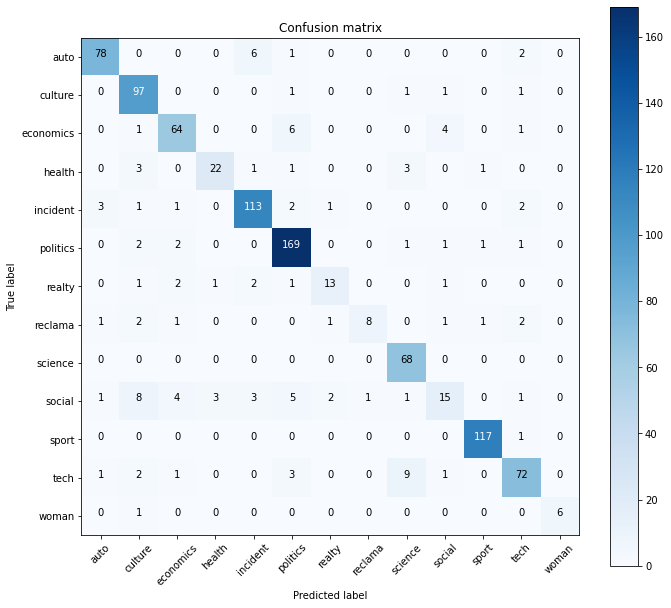

In [23]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [24]:
o = clf.predict(X)

In [25]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [26]:
for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: health
predict: health
Геморрагическая лихорадка продолжает наступление на Оренбуржье В Оренбургской
области продолжается высокий сезонный подъем заболеваемости геморрагической
лихорадкой с почечным синдромом. На 15 ноября ...
- - - - - - - - - - - - - - - - - -
tag: politics
predict: politics
Ради Кондолизы Райс в университете Шевченко вывесили новые шторы Около
350 человек собрались в актовом зале Национального университета им.
Тараса Шевченко в Киеве, где назначена встреча с государствен...
- - - - - - - - - - - - - - - - - -
tag: tech
predict: tech
Apple может инвестировать до $1 млрд в фонд, создаваемый SoftBank Apple Inc. может инвестировать до $1 млрд в фонд общим объемом $100 млрд, создаваемый японской телекоммуникационной компанией SoftBan...
- - - - - - - - - - - - - - - - - -
tag: social
predict: social
Минчанин тайно переночевал в батутном центре и стал звездой YouTube 5 декабря 2016 в 9:08 42.TUT.BY Минский блогер Влад Бумага вместе со своим другом провел ночь в закры

In [27]:
# https://habr.com/ru/post/205360/